# Load all of the required libraries

In [50]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import skimage 
from skimage import io

# Read in the input image for restoration, plot for confirmation and grab on the grayscale part of it

- We read in our jpeg
- Plot it for confirmation
- Read in only the bottom-most layer than contains the grayscale (intensities) therein, omitting colors

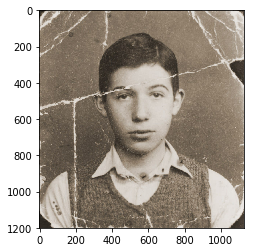

In [51]:
img = io.imread('dm4.jpg')
plt.imshow(img)
img = img[:,:,0]

# Plot the grayscale part for confirmation

- Here, we can see the image lose it's sepia tones, they are lost and only intensities in the range of 0 (white) to 1 (black) remain

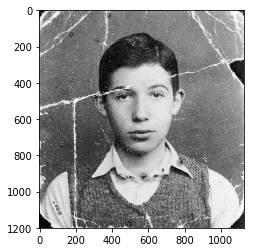

In [52]:
plt.imshow(img, cmap='gray')

# Import additional libraries for detecting creases within the image

In [53]:
from skimage.feature import canny 
from skimage.morphology import disk, binary_dilation, binary_erosion, remove_small_objects, watershed, opening, closing
from skimage.util import invert

# Lo and behold!

- Canny can help detect the creases in our image (basically any sharp changes in intensity will be captured)
- As a side effect, other features like the facial features (eyebrows, nose edges, hairline, etc.) are also unadvertendly captured alongside the intended image features

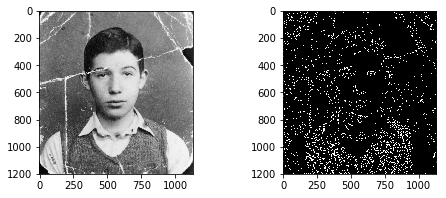

In [54]:
edges = canny(img)

fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].imshow(img, cmap='gray')
axes[1].imshow(edges, cmap='gray')

# Load a method from the scipy package that might help us enhance the image in some manner

In [55]:
from scipy.ndimage import binary_fill_holes

# Applying a combination of erosion, dilation on the image with holes filled in using our imported method

- The results are interesting, and seem to detect the silhoutte (or a resemblance of it) of the person in our image.
- This silhoutte, possibly, can be combined with the original image to enhance it in some manner

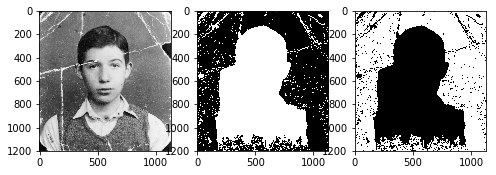

In [56]:
fill_img = binary_erosion(binary_fill_holes(binary_dilation(edges, disk(1))), disk(1))

fig, axes = plt.subplots(1,3, figsize=(8,3))

axes[0].imshow(img, cmap='gray')
axes[1].imshow(fill_img, cmap='gray')
axes[2].imshow(1-fill_img, cmap='gray')

## Removing small objects in the background to get a clearer image

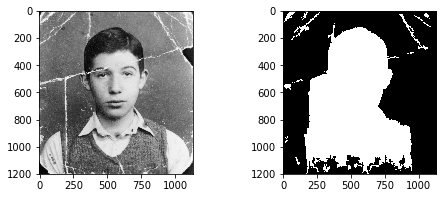

In [57]:
img_cleaned = remove_small_objects(fill_img,500)

fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].imshow(img, cmap='gray')
axes[1].imshow(img_cleaned, cmap='gray')

# Superimposing the image to get the cleaned version of image (wip)

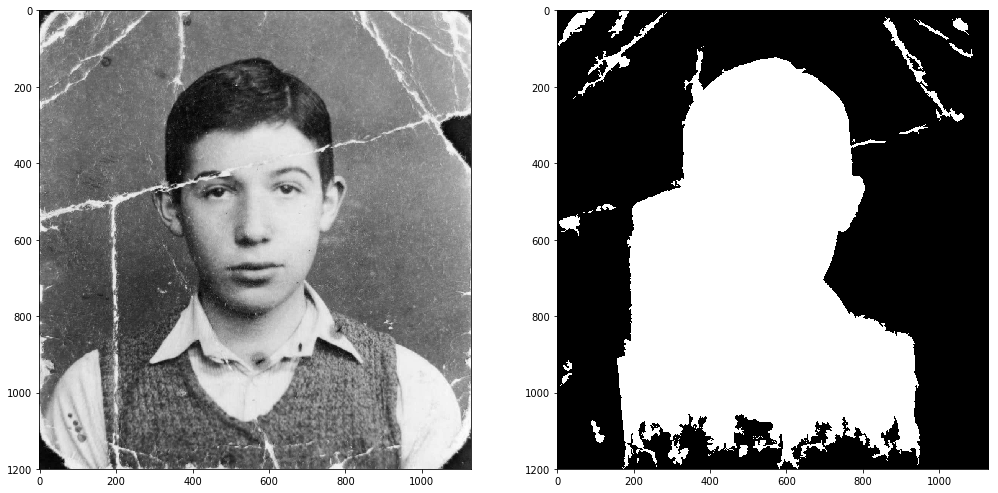

In [58]:
new = np.logical_xor(img,1-img_cleaned)

fig, axes = plt.subplots(1,2, figsize=(17,10))

axes[0].imshow(img, cmap='gray')
axes[1].imshow(new, cmap='gray')

## 'Rudin-Osher-Fatemi'

In [59]:
noisy = img + 0.5 * img.std() * np.random.random(img.shape)
noisy = np.clip(noisy, 0, 255)
U = denoise(noisy)

TypeError: denoise() missing 1 required positional argument: 'U_init'

In [15]:
type(U)

numpy.ndarray

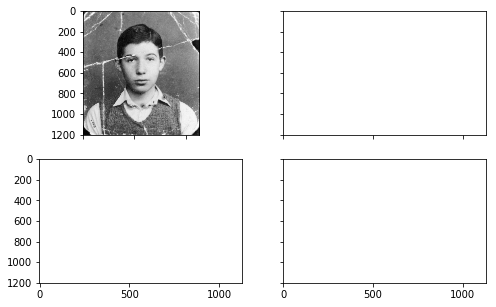

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()
ax[0, 0].imshow(X)

In [61]:
def denoise_new(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
        using the numerical procedure presented in Eq. (11) of A. Chambolle
        (2005). Implemented using periodic boundary conditions.
        
        Input: noisy input image (grayscale), initial guess for U, weight of 
        the TV-regularizing term, steplength, tolerance for the stop criterion
        
        Output: denoised and detextured image, texture residual. """
        
    m,n = im.shape #size of noisy image

    # initialize
    U = np.zeros_like(im)
    Px = im #x-component to the dual field
    Py = im #y-component of the dual field
    error = 1 
    
    while (error > tolerance):
        Uold = U
        
        # gradient of primal variable
        GradUx = roll(U,-1,axis=1)-U # x-component of U's gradient
        GradUy = roll(U,-1,axis=0)-U # y-component of U's gradient
        
        # update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx # non-normalized update of x-component (dual)
        PyNew = Py + (tau/tv_weight)*GradUy # non-normalized update of y-component (dual)
        NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))
        
        Px = PxNew/NormNew # update of x-component (dual)
        Py = PyNew/NormNew # update of y-component (dual)
        
        # update the primal variable
        RxPx = roll(Px,1,axis=1) # right x-translation of x-component
        RyPy = roll(Py,1,axis=0) # right y-translation of y-component
        
        DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
        U = im + tv_weight*DivP # update of the primal variable
        
        # update of error
        error = linalg.norm(U-Uold)/sqrt(n*m);
        
    return U # denoised image and texture residual

In [62]:
noisy = img + 0.5 * img.std() * np.random.random(img.shape)
noisy = np.clip(noisy, 0, 255)

In [63]:
from numpy import *

def denoise(im, U_init, tolerance=0.1, tau=0.125, tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
        using the numerical procedure presented in Eq. (11) of A. Chambolle
        (2005). Implemented using periodic boundary conditions 
        (essentially turning the rectangular image domain into a torus!).
    
        Input:
        im - noisy input image (grayscale)
        U_init - initial guess for U
        tv_weight - weight of the TV-regularizing term
        tau - steplength in the Chambolle algorithm
        tolerance - tolerance for determining the stop criterion
    
        Output:
        U - denoised and detextured image (also the primal variable)
        T - texture residual"""
    
    #---Initialization
    m,n = im.shape #size of noisy image

    U = U_init
    Px = im #x-component to the dual field
    Py = im #y-component of the dual field
    error = 1 
    iteration = 0

    #---Main iteration
    while (error > tolerance):
        Uold = U

        #Gradient of primal variable
        LyU = vstack((U[1:,:],U[0,:])) #Left translation w.r.t. the y-direction
        LxU = hstack((U[:,1:],U.take([0],axis=1))) #Left translation w.r.t. the x-direction

        GradUx = LxU-U #x-component of U's gradient
        GradUy = LyU-U #y-component of U's gradient

        #First we update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx #Non-normalized update of x-component (dual)
        PyNew = Py + (tau/tv_weight)*GradUy #Non-normalized update of y-component (dual)
        NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))

        Px = PxNew/NormNew #Update of x-component (dual)
        Py = PyNew/NormNew #Update of y-component (dual)

        #Then we update the primal variable
        RxPx =hstack((Px.take([-1],axis=1),Px[:,0:-1])) #Right x-translation of x-component
        RyPy = vstack((Py[-1,:],Py[0:-1,:])) #Right y-translation of y-component
        DivP = (Px-RxPx)+(Py-RyPy) #Divergence of the dual field.
        U = im + tv_weight*DivP #Update of the primal variable

        #Update of error-measure
        error = linalg.norm(U-Uold)/sqrt(n*m);
        iteration += 1;

        print(iteration, error)

    #The texture residual
    T = im - U
    print('Number of ROF iterations: ', iteration)
    
    return U,T

In [64]:
X,Y = denoise(img,np.zeros_like(img))

1 147.95506764542463
2 0.9281328372320394
3 0.66312258843517
4 0.5174690783863184
5 0.42666154149021507
6 0.3648223563493012
7 0.31991493335990834
8 0.2856929772852009
9 0.25867910559294277
10 0.23677588591065019
11 0.21865813021310765
12 0.20340797078526138
13 0.1903840040561765
14 0.17910507531537517
15 0.16923893531286613
16 0.16051421481836461
17 0.15275683131178477
18 0.14578095976697414
19 0.13947496201056767
20 0.1337710048033989
21 0.12855832338785375
22 0.12378787856308822
23 0.11937398826391367
24 0.1152696117702762
25 0.1114320099704375
26 0.10787353140494785
27 0.10456502844825682
28 0.10146126974553311
29 0.09857291991824535
Number of ROF iterations:  29


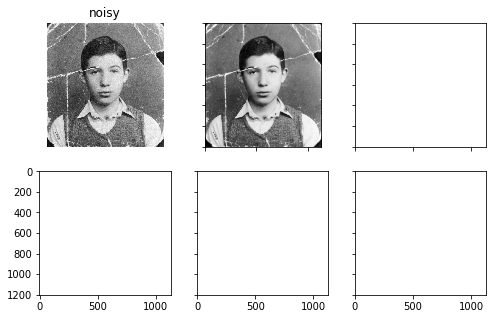

In [65]:

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()
ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(X)

In [40]:
noisy.shape

(1200, 1128)

In [13]:
img.shape

(1200, 1128)

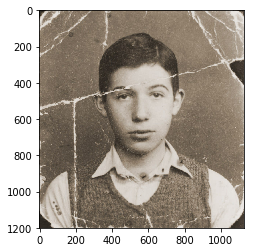

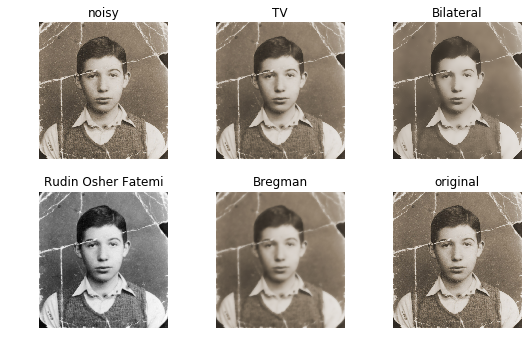

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral,denoise_tv_bregman
img = io.imread('dm4.jpg')
plt.imshow(img)

noisy = img + 0.6 * img.std() * np.random.random(img.shape)
noisy = np.clip(img, 0, 1)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()
ax[0, 0].imshow(img)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(denoise_tv_chambolle(img, weight=0.1, multichannel=True))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(img,sigma_color=0.05, sigma_spatial=15))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[1, 0].imshow(X)
ax[1, 0].axis('off')
ax[1, 0].set_title('Rudin Osher Fatemi')
ax[1, 1].imshow(denoise_tv_bregman(img, weight=0.1))
ax[1, 1].axis('off')
ax[1, 1].set_title('Bregman')
ax[1, 2].imshow(img)
ax[1, 2].axis('off')
ax[1, 2].set_title('original')

fig.tight_layout()